In [3]:
%matplotlib inline
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from matplotlib import pyplot
import seaborn as sns
import os

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

#logging
from myutil.logconf import logging
log = logging.getLogger(__name__)
# log.setLevel(logging.ERROR)
log.setLevel(logging.INFO)
# log.setLevel(logging.WARN)
# log.setLevel(logging.DEBUG)


#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = '{:.3f}'.format

torch.seed = 42
random.seed(42)
np.random.seed(42)

%run 'nb_utils.ipynb'
task_name = get_filename_of_ipynb()
print(task_name)
data_dir = f'{os.getcwd()}/data/'
log_dir_base = f'{os.getcwd()}/runs/{task_name}'
log_dir = log_dir_base
print(f'{data_dir}\n{log_dir}')


StockPCTLabelPredictLSTM
/mnt/AIWorkSpace/work/fin-ml/data/
/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM


In [4]:
# hyperparameters turning
from ray import tune, train, ray
from ray.tune.schedulers import ASHAScheduler

ray.init(log_to_driver=False)

2024-02-03 00:20:46,805	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.18
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8265


In [5]:
from datetime import datetime
import yfinance as yfin

# Loading the data
stk_symbols = [
    "AAPL",
    "MSFT",
    "AMZN",
    "NVDA",
    "GOOGL",
    "GOOG",
    "META",
    "TSLA",
    "UNH",
    "LLY",
    "JPM",
    "XOM",
    "JNJ",
    "V",
    "PG",
    "AVGO",
    "MA",
    "HD",
    "CVX",
    "MRK",
    "ABBV",
    "PEP",
    "COST",
    "ADBE",
    "KO",
    "CSCO",
    "WMT",
    "TMO",
    "MCD",
    "PFE",
    "CRM",
    "BAC",
    "ACN",
    "CMCSA",
    "LIN",
    "NFLX",
    "ABT",
    "ORCL",
    "DHR",
    "AMD",
    "WFC",
    "DIS",
    "TXN",
    "PM",
    "VZ",
    "INTU",
    "COP",
    "CAT",
    "AMGN",
    "NEE",
    "INTC",
    "UNP",
    "LOW",
    "IBM",
    "BMY",
    "SPGI",
    "RTX",
    "HON",
    "BA",
    "UPS",
    "GE",
    "QCOM",
    "AMAT",
    "NKE",
    "PLD",
    "NOW",
    "BKNG",
    "SBUX",
    "MS",
    "ELV",
    "MDT",
    "GS",
    "DE",
    "ADP",
    "LMT",
    "TJX",
    "T",
    "BLK",
    "ISRG",
    "MDLZ",
    "GILD",
    "MMC",
    "AXP",
    "SYK",
    "REGN",
    "VRTX",
    "ETN",
    "LRCX",
    "ADI",
    "SCHW",
    "CVS",
    "ZTS",
    "CI",
    "CB",
    "AMT",
    "SLB",
    "C",
    "BDX",
    "MO",
    "PGR",
    "TMUS",
    "FI",
    "SO",
    "EOG",
    "BSX",
    "CME",
    "EQIX",
    "MU",
    "DUK",
    "PANW",
    "PYPL",
    "AON",
    "SNPS",
    "ITW",
    "KLAC",
    "LULU",
    "ICE",
    "APD",
    "SHW",
    "CDNS",
    "CSX",
    "NOC",
    "CL",
    "MPC",
    "HUM",
    "FDX",
    "WM",
    "MCK",
    "TGT",
    "ORLY",
    "HCA",
    "FCX",
    "EMR",
    "PXD",
    "MMM",
    "MCO",
    "ROP",
    "CMG",
    "PSX",
    "MAR",
    "PH",
    "APH",
    "GD",
    "USB",
    "NXPI",
    "AJG",
    "NSC",
    "PNC",
    "VLO",
    "GBP",
    "F",
    "MSI",
    "GM",
    "TT",
    "EW",
    "CARR",
    "AZO",
    "ADSK",
    "TDG",
    "ANET",
    "SRE",
    "ECL",
    "OXY",
    "PCAR",
    "ADM",
    "MNST",
    "KMB",
    "PSA",
    "CCI",
    "CHTR",
    "MCHP",
    "MSCI",
    "CTAS",
    "WMB",
    "AIG",
    "STZ",
    "HES",
    "NUE",
    "ROST",
    "AFL",
    "AEP",
    "IDXX",
    "D",
    "TEL",
    "JCI",
    "MET",
    "GIS",
    "IQV",
    "EXC",
    "WELL",
    "DXCM",
    "HLT",
    "ON",
    "COF",
    "PAYX",
    "TFC",
    "USD",
    "BIIB",
    "O",
    "FTNT",
    "DOW",
    "TRV",
    "DLR",
    "MRNA",
    "CPRT",
    "ODFL",
    "DHI",
    "YUM",
    "SPG",
    "CTSH",
    "AME",
    "BKR",
    "SYY",
    "A",
    "CTVA",
    "CNC",
    "EL",
    "AMP",
    "CEG",  # PCT <= -0.05,  size = 0
    "HAL",
    "OTIS",  # PCT <= -0.05,  size = 0
    "ROK",
    "PRU",
    "DD",
    "KMI",
    "VRSK",
    "LHX",
    "DG",
    "FIS",
    "CMI",
    "CSGP",
    "FAST",
    "PPG",
    "GPN",
    "GWW",
    "HSY",
    "BK",
    "XEL",
    "DVN",
    "EA",
    "NEM",
    "ED",
    "URI",
    "VICI",
    "PEG",
    "KR",
    "RSG",
    "LEN",
    "PWR",
    "WST",
    "COR",
    "OKE",
    "VMC",
    "KDP",
    "WBD",
    "ACGL",
    "ALL",
    "IR",
    "CDW",
    "FANG",
    "MLM",
    "PCG",
    "DAL",
    "EXR",
    "FTV",
    "AWK",
    "IT",
    "KHC",
    "GEHC",  # PCT <= -0.05,  size = 0
    "WEC",
    "HPQ",
    "EIX",
    "CBRE",
    "APTV",
    "ANSS",
    "MTD",
    "DLTR",
    "AVB",
    "ILMN",
    "ALGN",
    "LYB",
    "TROW",
    "GLW",
    "EFX",
    "WY",
    "ZBH",
    "XYL",
    "SBAC",
    "RMD",
    "TSCO",
    "EBAY",
    "KEYS",
    "CHD",
    "STT",
    "DFS",
    "HIG",
    "ALB",
    "STE",
    "ES",
    "TTWO",
    "MPWR",
    "CAH",
    "EQR",
    "RCL",
    "WTW",
    "HPE",
    "DTE",
    "GPC",
    "BR",
    "ULTA",
    "FICO",
    "CTRA",
    "BAX",
    "AEE",
    "MTB",
    "MKC",
    "ETR",
    "WAB",
    "DOV",
    "FE",
    "RJF",
    "INVH",
    "FLT",
    "CLX",
    "TDY",
    "TRGP",
    "DRI",
    "LH",
    "HOLX",
    "VRSN",
    "MOH",
    "LUV",
    "PPL",
    "ARE",
    "NVR",
    "COO",
    "WBA",
    "PHM",
    "NDAQ",
    "HWM",
    "RF",
    "CNP",
    "IRM",
    "LVS",
    "FITB",
    "EXPD",
    "VTR",
    "FSLR",
    "PFG",
    "BRO",
    "J",
    "IEX",
    "BG",
    "ATO",
    "FDS",
    "ENPH",
    "MAA",
    "CMS",
    "IFF",
    "BALL",
    "SWKS",
    "CINF",
    "NTAP",
    "STLD",
    "UAL",
    "WAT",
    "OMC",
    "TER",
    "CCL",
    "JBHT",
    "MRO",
    "TYL",
    "HBAN",
    "K",
    "GRMN",
    "CBOE",
    "NTRS",
    "TSN",
    "AKAM",
    "EG",
    "ESS",
    "EQT",
    "TXT",
    "EXPE",
    "SJM",
    "PTC",
    "DGX",
    "AVY",
    "RVTY",
    "BBY",
    "CF",
    "CAG",
    "EPAM",
    "AMCR",
    "LW",
    "PAYC",
    "SNA",
    "AXON",
    "POOL",
    "SYF",
    "SWK",
    "ZBRA",
    "DPZ",
    "PKG",
    "CFG",
    "LDOS",
    "VTRS",
    "PODD",
    "LKQ",
    "MOS",
    "APA",
    "EVRG",
    "TRMB",
    "MGM",
    "NDSN",
    "WDC",
    "MAS",
    "LNT",
    "IPG",
    "MTCH",
    "STX",
    "KMX",
    "TECH",
    "WRB",
    "LYV",
    "IP",
    "UDR",
    "AES",
    "CE",
    "INCY",
    "L",
    "TAP",
    "GEN",
    "CPT",
    "KIM",
    "JKHY",
    "HRL",
    "HST",
    "FMC",
    "CZR",
    "PEAK",
    "CDAY",
    "PNR",
    "NI",
    "CHRW",
    "HSIC",
    "CRL",
    "REG",
    "QRVO",
    "TFX",
    "KEY",
    "GL",
    "EMN",
    "WYNN",
    "ALLE",
    "AAL",
    "FFIV",
    "BWA",
    "BXP",
    "MKTX",
    "ROL",
    "JNPR",
    "PNW",
    "ETSY",
    "BLDR",
    "FOXA",
    "AOS",
    "HAS",
    "HII",
    "NRG",
    "CPB",
    "UHS",
    "BIO",
    "WRK",
    "RHI",
    "CTLT",
    "XRAY",
    "BBWI",
    "NWSA",
    "TPR",
    "PARA",
    "WHR",
    "BEN",
    "AIZ",
    "NCLH",
    "GNRC",
    "FRT",
    "IVZ",
    "VFC",
    "CMA",
    "DVA",
    "JBL",
    "HUBB",
    "ZION",
    "UBER",
    "MHK",
    "RL",
    "FOX",
    "BX",
    "ABNB",
    "NWS",
]
# stk_tickers = [
#     "AAPL",
#     "MSFT",
#     "AMZN",
#     "NVDA",
#     "GOOGL",
#     "TSLA",
#     "META",
#     "GOOG",
#     "ADBE",
#     "NFLX",
#     "CSCO",
#     "INTC",
#     "INTU",
#     "CMCSA",
#     "TXN",
#     "AMAT",
#     "ADSK",
#     "AMD",
#     "QCOM",
#     "MU",
# ]
start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)

ticks_data = []
for symbol in stk_symbols:
    stk_file = f"{data_dir}{symbol}.csv"
    bLoad = False
    if os.path.isfile(stk_file):
        try:
            _stk_data = pd.read_csv(stk_file).set_index("Date")
            bLoad = True
            print(f"read {stk_file} completely!")
        except:
            None
    if bLoad == False:
        # _stk_data = web.get_data_yahoo(stk_tickers, start, end)
        _stk_data = yfin.download([symbol], start, end).dropna()
        _stk_data.to_csv(stk_file)
        print(f"download {symbol} from yfin and write to {stk_file} completely!")
    ticks_data.append(_stk_data)
    print(f"{symbol}, size:{len(_stk_data)}")

read /mnt/AIWorkSpace/work/fin-ml/data/AAPL.csv completely!
AAPL, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/MSFT.csv completely!
MSFT, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/AMZN.csv completely!
AMZN, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/NVDA.csv completely!
NVDA, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/GOOGL.csv completely!
GOOGL, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/GOOG.csv completely!
GOOG, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/META.csv completely!
META, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/TSLA.csv completely!
TSLA, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/UNH.csv completely!
UNH, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/LLY.csv completely!
LLY, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/JPM.csv completely!
JPM, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/XOM.csv completely!
XOM, size:2516
read /mnt/AIWorkSpace/work/fin-ml/data/JNJ.csv completely!
JNJ, size:2516
read /mnt/AIWorkSpac

In [6]:
import torch

device_name = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device = torch.device(device_name)
return_period = 5
seq_len = 3
validation_size = 0.2
epoch_num = 100
batch_size = 32
num_workers = 2
pin_memory = True
shuffle = True
print(f"device_name:{device}")

device_name:cuda


In [7]:
pct_threshold = 0.05
class_percentage_threshold = 0.08  # percentage threshold for class size
classificationThreshold = 0.5


# number of classes = 3
# 0: PCT <= -0.05
# 1: 0.05 < PCT < -0.05
# 2: PCT >= -0.05
# num_classes = 3

# def gen_pct_label(stk_data, _return_period):
#     max_price_period = (
#         stk_data["Adj Close"].rolling(_return_period).max().shift(-_return_period)
#     )
#     max_pct_period = (max_price_period - stk_data["Adj Close"]) / stk_data["Adj Close"]
#     pct_label = max_pct_period.apply(
#         lambda x: 2 if x >= pct_threshold else 0 if x <= -pct_threshold else 1
#     ).astype("int8")
#     pct_label.name = "label"
#     return pct_label


# number of classes = 2
# 0: PCT < 0.05
# 1: PCT >= -0.05
num_classes = 2


def gen_pct_label(stk_data, _return_period):
    max_price_period = (
        stk_data["Adj Close"].rolling(_return_period).max().shift(-_return_period)
    )
    max_pct_period = (max_price_period - stk_data["Adj Close"]) / stk_data["Adj Close"]
    pct_label = max_pct_period.apply(lambda x: 1 if x >= pct_threshold else 0).astype(
        "int8"
    )
    pct_label.name = "label"
    return pct_label


def class_percentage(analysis_data):
    stat = analysis_data.groupby("label").size()
    total = len(analysis_data)
    p = []
    for i in range(num_classes):
        p.append(stat[i] / total if i in stat.index else 0.0)
    return p

In [8]:
def gen_buy_sell_signal(stk_data):
    import pandas_ta as ta

    sma = pd.concat(
        [
            stk_data.ta.sma(close="Adj Close", length=10),
            stk_data.ta.sma(close="Adj Close", length=60),
        ],
        axis=1,
    ).dropna()
    buy_signal = sma["SMA_10"] > sma["SMA_60"]

    buy_sell_signal = stk_data[[]].copy()
    buy_sell_signal["Signal"] = (buy_signal).astype("int")

    return buy_sell_signal


def gen_analysis_data(stk_data, _return_period):
    import pandas_ta as ta

    data = pd.concat(
        [
            stk_data.ta.adosc(),
            stk_data.ta.kvo(),
            stk_data.ta.rsi(close="Adj Close", length=10) / 100,
            stk_data.ta.rsi(close="Adj Close", length=30) / 100,
            stk_data.ta.rsi(close="Adj Close", length=200) / 100,
            stk_data.ta.stoch(k=10) / 100,
            stk_data.ta.stoch(k=30) / 100,
            stk_data.ta.stoch(k=200) / 100,
            gen_buy_sell_signal(stk_data),
        ],
        axis=1,
    )

    data = pd.concat(
        [data.astype("float32"), gen_pct_label(stk_data, _return_period)],
        axis=1,
    ).dropna()
    return data


def prepare_dataset(_return_period, verbose=False):
    from tqdm import tqdm

    ticks_dataset = []
    ignore_ticks_data_count = 0
    for i, tick_data in enumerate(tqdm(ticks_data)):
        analysis_data = gen_analysis_data(tick_data, _return_period)
        classes_percentage = class_percentage(analysis_data)
        if 0 in classes_percentage:
            if verbose:
                print(
                    f"Some classes don't have any data  : {stk_symbols[i]}, {classes_percentage}"
                )
            ignore_ticks_data_count += 1
        elif any(p < class_percentage_threshold for p in classes_percentage):
            if verbose:
                print(
                    f"Some classes are too small  : {stk_symbols[i]}, {classes_percentage}"
                )
            ignore_ticks_data_count += 1
        else:
            ticks_dataset.append(analysis_data)
    if ignore_ticks_data_count > 0:
        print(
            f"There are {ignore_ticks_data_count} stocks in total, some classes have no data or are too small"
        )
    return ticks_dataset

In [63]:
ttt = prepare_dataset(5)

Some classes are too small  : JNJ, [0.975789018590575, 0.02421098140942499]
Some classes are too small  : V, [0.9295287505404237, 0.07047124945957631]
Some classes are too small  : PG, [0.9775183744055339, 0.02248162559446606]
Some classes are too small  : HD, [0.9303934284479032, 0.06960657155209685]
Some classes are too small  : MRK, [0.9463899697362732, 0.05361003026372676]
Some classes are too small  : PEP, [0.9818417639429312, 0.018158236057068743]
Some classes are too small  : COST, [0.9364461738002594, 0.06355382619974059]
Some classes are too small  : KO, [0.9783830523130134, 0.021616947686986597]
Some classes are too small  : CSCO, [0.9286640726329443, 0.07133592736705577]
Some classes are too small  : WMT, [0.9485516645049719, 0.0514483354950281]
Some classes are too small  : MCD, [0.958063121487246, 0.041936878512753996]
Some classes are too small  : PFE, [0.9217466493731085, 0.07825335062689148]
Some classes are too small  : ACN, [0.9286640726329443, 0.07133592736705577]
So

In [42]:
def class_percentage(stk_data):
    stat = stk_data.groupby("label").size()
    total = len(stk_data)
    p = []
    for i in range(num_classes):
        p.append(stat[i] / total if i in stat.index else 0.0)
    return p


r = class_percentage(gen_analysis_data(ticks_data[0], return_period))

print(r)

[0.8767833981841764, 0.12321660181582361]


   AAPL  MSFT  AMZN  NVDA  GOOGL  GOOG  META  TSLA   UNH   LLY   JPM   XOM   JNJ     V    PG  AVGO    MA    HD   CVX   MRK  ABBV   PEP  COST  ADBE    KO  CSCO   WMT   TMO   MCD   PFE   CRM   BAC   ACN  CMCSA   LIN  NFLX   ABT  ORCL   DHR   AMD   WFC   DIS   TXN    PM    VZ  INTU   COP   CAT  AMGN   NEE  INTC   UNP   LOW   IBM   BMY  SPGI   RTX   HON    BA   UPS    GE  QCOM  AMAT   NKE   PLD   NOW  BKNG  SBUX    MS   ELV   MDT    GS    DE   ADP   LMT   TJX     T   BLK  ISRG  MDLZ  GILD   MMC   AXP   SYK  REGN  VRTX   ETN  LRCX   ADI  SCHW   CVS   ZTS    CI    CB   AMT   SLB     C   BDX    MO   PGR  TMUS    FI    SO   EOG   BSX   CME  EQIX    MU   DUK  PANW  PYPL   AON  SNPS   ITW  KLAC  LULU   ICE   APD   SHW  CDNS   CSX   NOC    CL   MPC   HUM   FDX    WM   MCK   TGT  ORLY   HCA   FCX   EMR   PXD   MMM   MCO   ROP   CMG   PSX   MAR    PH   APH    GD   USB  NXPI   AJG   NSC   PNC   VLO   GBP     F   MSI    GM    TT    EW  CARR   AZO  ADSK   TDG  ANET   SRE   ECL   OXY  PCAR   ADM  MNST 

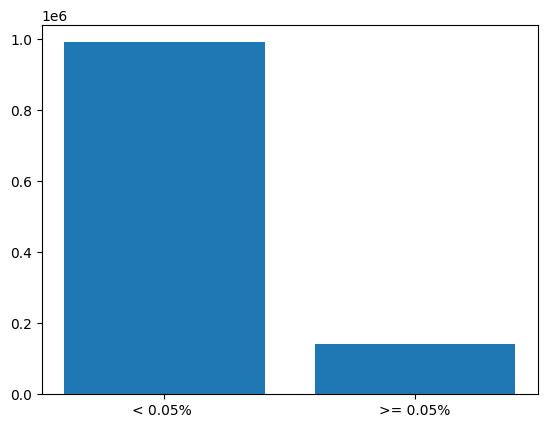

In [7]:
classes_df = pd.DataFrame()
for i, stk_data in enumerate(ticks_data):
    label_stat = gen_analysis_data(stk_data, return_period).groupby("label").size()
    label_stat.name = stk_symbols[i]
    classes_df = pd.concat([classes_df, label_stat], axis=1)
print(classes_df)
classes_count = [classes_df.iloc[i].sum() for i in range(num_classes)]
total_recs = sum(classes_count)
for i, v in enumerate(classes_count):
    print(f"class {i}: {v*100/total_recs:.3f}%, {v}")
pyplot.bar(["< 0.05% ", ">= 0.05%"], classes_count)
pyplot.show()

In [8]:
classes_df = pd.DataFrame()
for i, stk_data in enumerate(ticks_data):
    label_stat = gen_analysis_data(stk_data, return_period).groupby("label").size()
    label_stat.name = stk_symbols[i]
    classes_df = pd.concat([classes_df, label_stat], axis=1)
print(classes_df)
# classes_count = [classes_df.iloc[i].sum() for i in range(num_classes)]
# total_recs = sum(classes_count)
# for i, v in enumerate(classes_count):
#     print(f"class {i}: {v*100/total_recs:.3f}%, {v}")
# pyplot.bar(["<= -0.5%", " between ", ">= 0.05%"], classes_count)
# pyplot.show()

   AAPL  MSFT  AMZN  NVDA  GOOGL  GOOG  META  TSLA   UNH   LLY   JPM   XOM   JNJ     V    PG  AVGO    MA    HD   CVX   MRK  ABBV   PEP  COST  ADBE    KO  CSCO   WMT   TMO   MCD   PFE   CRM   BAC   ACN  CMCSA   LIN  NFLX   ABT  ORCL   DHR   AMD   WFC   DIS   TXN    PM    VZ  INTU   COP   CAT  AMGN   NEE  INTC   UNP   LOW   IBM   BMY  SPGI   RTX   HON    BA   UPS    GE  QCOM  AMAT   NKE   PLD   NOW  BKNG  SBUX    MS   ELV   MDT    GS    DE   ADP   LMT   TJX     T   BLK  ISRG  MDLZ  GILD   MMC   AXP   SYK  REGN  VRTX   ETN  LRCX   ADI  SCHW   CVS   ZTS    CI    CB   AMT   SLB     C   BDX    MO   PGR  TMUS    FI    SO   EOG   BSX   CME  EQIX    MU   DUK  PANW  PYPL   AON  SNPS   ITW  KLAC  LULU   ICE   APD   SHW  CDNS   CSX   NOC    CL   MPC   HUM   FDX    WM   MCK   TGT  ORLY   HCA   FCX   EMR   PXD   MMM   MCO   ROP   CMG   PSX   MAR    PH   APH    GD   USB  NXPI   AJG   NSC   PNC   VLO   GBP     F   MSI    GM    TT    EW  CARR   AZO  ADSK   TDG  ANET   SRE   ECL   OXY  PCAR   ADM  MNST 

In [14]:
classes_df_t = classes_df.T
classes_df_t["pos_%"] = classes_df_t[1] / (classes_df_t[0] + classes_df_t[1])
sorted = classes_df_t.sort_values("pos_%")
print(sorted)

         0     1  pos_%
GBP   1687     5  0.003
PEP   2271    42  0.018
KO    2263    50  0.022
PG    2261    52  0.022
JNJ   2257    56  0.024
...    ...   ...    ...
ETSY  1300   690  0.347
AMD   1424   889  0.384
USD   1391   922  0.399
MRNA   623   448  0.418
ENPH  1281  1032  0.446

[501 rows x 3 columns]


In [20]:
too_small = classes_df_t[classes_df_t["pos_%"] < stk_pos_threshold]  # 0.08
print(too_small)

         0    1  pos_%
JNJ   2257   56  0.024
V     2150  163  0.070
PG    2261   52  0.022
HD    2152  161  0.070
MRK   2189  124  0.054
...    ...  ...    ...
CHRW  2131  182  0.079
GL    2191  122  0.053
PNW   2198  115  0.050
CPB   2159  154  0.067
AIZ   2139  174  0.075

[135 rows x 3 columns]


          0    1
AAPL   2028  285
MSFT   2099  214
AMZN   1943  370
NVDA   1606  707
GOOGL  2078  235
...     ...  ...
RL     1871  442
FOX     853  154
BX     1883  430
ABNB    385  180
NWS    2026  287

[501 rows x 2 columns]


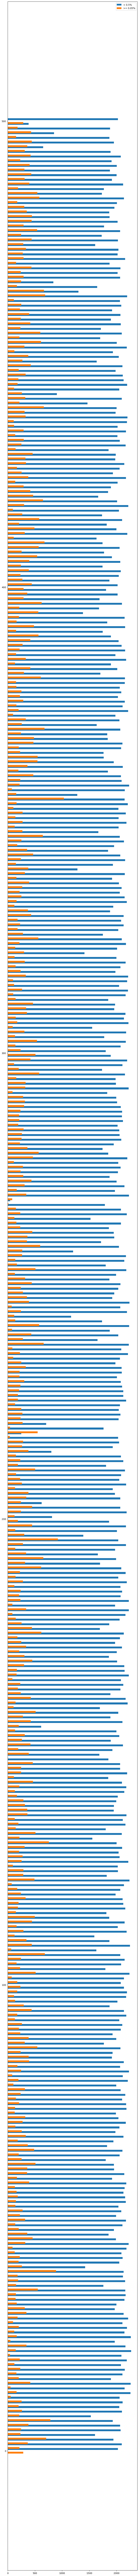

In [10]:
classes_df_t = classes_df.T
print(classes_df_t)
fig, ax = pyplot.subplots(figsize=(10, 200))
# pyplot.tight_layout()
labels = classes_df_t.index
width = 0.4  # the width of the bars
y = np.arange(len(labels))
ax.barh(y + width, classes_df_t[0], width, label="< 0.5%")
ax.barh(y - width, classes_df_t[1], width, label=">= 0.05%")

ax.legend()

pyplot.show()

In [ ]:
print(stk_symbols.index("CEG"))
print(stk_symbols.index("OTIS"))
print(stk_symbols.index("GEHC"))

In [52]:
with pd.option_context("display.max_rows", None):
    classes_df_t = classes_df.T
    print(classes_df_t[classes_df_t.isna().any(axis=1)])

Empty DataFrame
Columns: [0, 1, 2]
Index: []


In [9]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class LSTMDataSet(Dataset):
    def __init__(
        self,
        ticks_data_X,
        ticks_data_Y,
        _seq_len,
    ):
        self.ticks_data_X = ticks_data_X
        self.ticks_data_Y = ticks_data_Y
        self.seq_len = _seq_len
        len_array = [len(d) - self.seq_len + 1 for d in ticks_data_X]
        self.idx_boundary = [len_array[0]]

        for i in range(1, len(len_array)):
            self.idx_boundary.append(len_array[i] + self.idx_boundary[i - 1])

        self.build_class_indices()
        self.max_class_size = max(
            [len(class_index) for class_index in self.class_indices]
        )
        # print(self.idx_boundary[-1])
        # print(self.__len__())

    def build_class_indices(self):
        total_y = pd.concat(
            [t[self.seq_len - 1 :]["label"] for t in self.ticks_data_Y]
        ).reset_index()
        self.class_indices = []
        for i in range(num_classes):
            class_idx_list = total_y.index[total_y["label"] == i].tolist()
            random.shuffle(class_idx_list)
            self.class_indices.append(class_idx_list)

    def __len__(self):
        # print(f"len of dataset:{self.idx_boundary[-1]}")
        # return self.idx_boundary[-1]  # len(self.X) - self.seq_len + 1
        return self.max_class_size * num_classes

    def idx_of_balanced_data_to_original_idx(self, idx_of_balanced_data):
        selected_class = idx_of_balanced_data % num_classes
        idx_of_balanced_class = idx_of_balanced_data // num_classes
        offset_balanced_class = idx_of_balanced_class % len(
            self.class_indices[selected_class]
        )
        return self.class_indices[selected_class][offset_balanced_class]

    def __getitem__(self, idx_of_balanced_data):
        idx = self.idx_of_balanced_data_to_original_idx(idx_of_balanced_data)

        # print(f"getitem, idx_of_balanced_data:{idx_of_balanced_data}, idx:{idx}")
        for ticks_data_idx in range(len(self.ticks_data_X)):
            if self.idx_boundary[ticks_data_idx] > idx:
                break
        offset = (
            idx if ticks_data_idx == 0 else idx - self.idx_boundary[ticks_data_idx - 1]
        )
        # print(f"{ticks_data_idx}, {offset}")
        # print(f"{len(self.ticks_data_Y[ticks_data_idx])}, {offset + self.seq_len - 1}")
        x = np.array(self.ticks_data_X[ticks_data_idx][offset : offset + self.seq_len])
        y = int(self.ticks_data_Y[ticks_data_idx].iloc[offset + self.seq_len - 1, :])
        # if x.shape[1] == 34:
        #     print(f"sssssssssssssssssssssssssss {ticks_data_idx}, {idx}")
        return (x, y)

In [8]:
t = prepare_dataset(return_period)

100%|██████████| 501/501 [00:05<00:00, 98.52it/s] 

There are 135 stocks in total, some classes have no data or are too small


In [9]:
print(len(t))

366


In [32]:
import random
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper

_return_period = return_period
_seq_len = seq_len


ticks_dataset = [gen_analysis_data(d, _return_period) for d in ticks_data]
ticks_X_train_data = []
ticks_Y_train_data = []
ticks_X_test_data = []
ticks_Y_test_data = []
ticks_X_dfm = []
for dataset in ticks_dataset:
    # test_size = int(dataset.shape[0] * validation_size)
    train_size = int(dataset.shape[0] * (1 - validation_size))
    # random.seed(42)
    train_data = dataset.iloc[0:train_size]
    test_data = dataset.iloc[train_size - seq_len + 1 :]

    X_train_data = train_data.iloc[:, :-1]
    Y_train_data = train_data.iloc[:, -1:]

    X_test_data = test_data.iloc[:, :-1]
    Y_test_data = test_data.iloc[:, -1:]

    features = [
        ([column], StandardScaler()) for column in X_train_data.columns[:3].values
    ]
    features.extend([([column], None) for column in X_train_data.columns[3:].values])
    # print(features)
    X_dfm = DataFrameMapper(features, input_df=True, df_out=True)
    X_train_data = X_dfm.fit_transform(X_train_data)
    X_test_data = X_dfm.transform(X_test_data)

    ticks_X_dfm.append(X_dfm)
    ticks_X_train_data.append(X_train_data)
    ticks_Y_train_data.append(Y_train_data)
    ticks_X_test_data.append(X_test_data)
    ticks_Y_test_data.append(Y_test_data)

train_ds = LSTMDataSet(ticks_X_train_data, ticks_Y_train_data, _seq_len)
test_ds = LSTMDataSet(ticks_X_test_data, ticks_Y_test_data, _seq_len)

2024-02-01 17:36:30,709 INFO     pid:15618 sklearn_pandas:343:_transform [FIT_TRANSFORM] ['ADOSC_3_10']: 0.000918 secs
2024-02-01 17:36:30,710 INFO     pid:15618 sklearn_pandas:343:_transform [FIT_TRANSFORM] ['KVO_34_55_13']: 0.000967 secs
2024-02-01 17:36:30,712 INFO     pid:15618 sklearn_pandas:343:_transform [FIT_TRANSFORM] ['KVOs_34_55_13']: 0.000737 secs
2024-02-01 17:36:30,715 INFO     pid:15618 sklearn_pandas:353:_transform [TRANSFORM] ['ADOSC_3_10']: 0.000341 secs
2024-02-01 17:36:30,716 INFO     pid:15618 sklearn_pandas:353:_transform [TRANSFORM] ['KVO_34_55_13']: 0.000327 secs
2024-02-01 17:36:30,716 INFO     pid:15618 sklearn_pandas:353:_transform [TRANSFORM] ['KVOs_34_55_13']: 0.000328 secs
2024-02-01 17:36:30,720 INFO     pid:15618 sklearn_pandas:343:_transform [FIT_TRANSFORM] ['ADOSC_3_10']: 0.000834 secs
2024-02-01 17:36:30,721 INFO     pid:15618 sklearn_pandas:343:_transform [FIT_TRANSFORM] ['KVO_34_55_13']: 0.000821 secs
2024-02-01 17:36:30,723 INFO     pid:15618 sklea

36960
92136
9260
20934


In [54]:
d = ticks_data[180]
x = gen_analysis_data(d, return_period)
print(f"{stk_tickers[180]}, {len(x.columns)}")
# print(ticks_data[180])
# print(x)

print(d.ta.adosc())
print(d.ta.kvo())
print(d.ta.rsi(close="Adj Close", length=10) / 100)
print(d.ta.rsi(close="Adj Close", length=30) / 100)
print(d.ta.rsi(close="Adj Close", length=200) / 100)
print(d.ta.stoch(k=10) / 100)
print(d.ta.stoch(k=30) / 100)
print(d.ta.stoch(k=200) / 100)
print(gen_buy_sell_signal(d))

# data = pd.concat(
#     [data.astype("float32"), gen_pct_label(stk_data, _return_period)],
#     axis=1,
# ).dropna()
# return data

KVUE, 23
Date
2023-05-04            NaN
2023-05-05            NaN
2023-05-08            NaN
2023-05-09            NaN
2023-05-10            NaN
                 ...     
2023-12-22   -3787221.485
2023-12-26   -2217103.885
2023-12-27    2079808.214
2023-12-28    2651561.239
2023-12-29    4845022.046
Name: ADOSC_3_10, Length: 166, dtype: float64
            KVO_34_55_13  KVOs_34_55_13
Date                                   
2023-05-04           NaN            NaN
2023-05-05           NaN            NaN
2023-05-08           NaN            NaN
2023-05-09           NaN            NaN
2023-05-10           NaN            NaN
...                  ...            ...
2023-12-22   2026460.159    2724407.594
2023-12-26   1659098.235    2572220.543
2023-12-27   1728448.571    2451681.690
2023-12-28   1729998.318    2348584.065
2023-12-29   1352791.000    2206327.913

[166 rows x 2 columns]
Date
2023-05-04     NaN
2023-05-05     NaN
2023-05-08     NaN
2023-05-09     NaN
2023-05-10     NaN
          

In [10]:
import random
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def prepare_LSTMDataset(_return_period, _seq_len):
    ticks_dataset = prepare_dataset(_return_period)
    ticks_X_train_data = []
    ticks_Y_train_data = []
    ticks_X_test_data = []
    ticks_Y_test_data = []
    ticks_X_dfm = []
    for dataset in ticks_dataset:
        # test_size = int(dataset.shape[0] * validation_size)
        train_size = int(dataset.shape[0] * (1 - validation_size))
        # random.seed(42)
        train_data = dataset.iloc[0:train_size]
        test_data = dataset.iloc[train_size - seq_len + 1 :]

        X_train_data = train_data.iloc[:, :-1]
        Y_train_data = train_data.iloc[:, -1:]

        X_test_data = test_data.iloc[:, :-1]
        Y_test_data = test_data.iloc[:, -1:]

        features = [
            ([column], StandardScaler()) for column in X_train_data.columns[:3].values
        ]
        features.extend(
            [([column], None) for column in X_train_data.columns[3:].values]
        )
        # print(features)
        X_dfm = DataFrameMapper(features, input_df=True, df_out=True)
        X_train_data = X_dfm.fit_transform(X_train_data)
        X_test_data = X_dfm.transform(X_test_data)

        ticks_X_dfm.append(X_dfm)
        ticks_X_train_data.append(X_train_data)
        ticks_Y_train_data.append(Y_train_data)
        ticks_X_test_data.append(X_test_data)
        ticks_Y_test_data.append(Y_test_data)

    return [
        LSTMDataSet(ticks_X_train_data, ticks_Y_train_data, _seq_len),
        LSTMDataSet(ticks_X_test_data, ticks_Y_test_data, _seq_len),
    ]

In [9]:
import random
import math
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn_pandas import DataFrameMapper


def prepare_dataloader(_return_period, _seq_len):
    data = prepare_LSTMDataset(_return_period, _seq_len)

    train_loader = DataLoader(
        data[0],
        batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )
    test_loader = DataLoader(
        data[1],
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )

    return train_loader, test_loader, data[0].ticks_data_X[0].shape[1]

In [101]:
ds = t_r.dataset
# print(ds.ticks_data_Y[0][2:39])
print(ds.class_indices[1][:20])
print(ds.class_indices[0][:20])
print(ds.__getitem__(1))
print(ds.ticks_data_Y[0].head(20))
print(ds.ticks_data_X[0].head(20))
print(ds.ticks_data_X[0][12:15])

[12, 36, 48, 49, 56, 57, 59, 60, 61, 62, 63, 70, 71, 72, 73, 93, 176, 177, 178, 179]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20]
(array([[2.528885  , 0.43020323, 0.41524336, 0.7508403 , 0.6468546 ,
        0.5929855 , 0.75881785, 0.78068274, 0.90454125, 0.9036594 ,
        0.9637288 , 0.9633937 , 1.        ],
       [2.016737  , 0.03446712, 0.36264643, 0.7330403 , 0.64248574,
        0.5923124 , 0.73179203, 0.7508734 , 0.9038799 , 0.9013078 ,
        0.9634775 , 0.96250015, 1.        ],
       [1.9672475 , 0.1624415 , 0.34040493, 0.76318556, 0.65416276,
        0.5945477 , 0.77876943, 0.7564598 , 0.92592573, 0.91144896,
        0.97185415, 0.9663535 , 1.        ]], dtype=float32), 1)
            label
Date             
2014-10-22      0
2014-10-23      0
2014-10-24      0
2014-10-27      0
2014-10-28      0
2014-10-29      0
2014-10-30      0
2014-10-31      0
2014-11-03      0
2014-11-04      0
2014-11-05      0
2014-11-06      0
2014-11-07      0
2014-11-10

In [11]:
from torch import nn


class StockPCTLabelPredictLSTM(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_fc_layers,
        activation_type,
    ):
        super().__init__()
        self.setup_model(
            input_size,
            hidden_size,
            num_layers,
            num_fc_layers,
            activation_type,
        )

    def __init__(self, input_size, config):
        super().__init__()
        self.setup_model(
            input_size=input_size,
            hidden_size=config["hidden_size"],
            num_layers=config["num_layers"],
            num_fc_layers=config["num_fc_layers"],
            activation_type=config["activation_type"],
        )

    def setup_model(
        self,
        input_size,
        hidden_size,
        num_layers,
        num_fc_layers,
        activation_type,
    ):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        """
            input_size    : The number of expected features in the input x
            hidden_size   : The number of features in the hidden state h
            num_layers    : Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first LSTM and computing the final results. Default: 1
            bias          : If False, then the layer does not use bias weights b_ih and b_hh. Default: True
            batch_first   : If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False
            dropout       : If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to dropout. Default: 0
            bidirectional : If True, becomes a bidirectional LSTM. Default: False
            proj_size     : If > 0, will use LSTM with projections of corresponding size. Default: 0
        """
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        layers = []
        in_features = self.hidden_size
        for i in range(1, num_fc_layers):
            out_features = int(in_features / 2)
            if out_features <= num_classes:
                break
            layers.append(nn.Linear(in_features, out_features))
            (
                layers.append(nn.ReLU() if activation_type == 1 else nn.Sigmoid())
                if activation_type == 2
                else nn.Tanh()
            )
            in_features = out_features

        layers.append(nn.Linear(in_features, num_classes))
        self.fc = nn.Sequential(*layers)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            initrange = 0.5
            nn.init.uniform_(m.weight, -initrange, initrange)
            nn.init.zeros_(m.bias)
            # print(f"{m.in_features},{m.out_features}")

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(device)
        out, (h_out, _) = self.rnn(x, (h_0, c_0))

        fc_input = h_out[-1].view(-1, self.hidden_size)
        return self.fc(fc_input)


def save_model(model, hyper_parameters, file_path, epoch_num=None):
    state = {
        "epoch_num": epoch_num,
        "time": str(datetime.now),
        "model_state": model.state_dict(),
        "input_size": model.input_size,
        "hyper_parameters": hyper_parameters,
    }
    # print(f"save model:{file_path}")
    torch.save(state, file_path)


def load_model(file_path):
    data_dict = torch.load(file_path)
    hyper_parameters = data_dict["hyper_parameters"]
    model = StockPCTLabelPredictLSTM(
        input_size=data_dict["input_size"],
        hidden_size=int(hyper_parameters["hidden_size"]),
        num_layers=int(hyper_parameters["num_layers"]),
        num_fc_layers=int(hyper_parameters["num_fc_layers"]),
        activation_type=int(hyper_parameters["activation_type"]),
    )
    model.load_state_dict(data_dict["model_state"])
    return model, hyper_parameters

In [12]:
import torch.nn as nn

METRICS_LABEL_NDX = 0  # ground_truth
METRICS_PBTY_NDX = 1  # Probability of predicition
METRICS_PRED_NDX = 2  # class(label) of predicition
METRICS_LOSS_NDX = 3
METRICS_SIZE = 4
softmax = nn.Softmax(dim=1)
totalTrainingSamples_count = 0

In [13]:
from collections import namedtuple
from torch.utils.tensorboard import SummaryWriter


def logMetrics(
    epoch_ndx,
    mode_str,
    metrics_t,
    classificationThreshold=0.5,
):
    log.info(
        "E{} {}".format(
            epoch_ndx,
            task_name,
        )
    )
    F1_rec = namedtuple(
        "f1_rec",
        "target_class pos_correct neg_correct pos_count neg_count pos_loss neg_loss precision recall F1",
    )
    F1_metrics = []
    for target_class in reversed(range(num_classes)):
        posLabel_mask = metrics_t[METRICS_LABEL_NDX] == target_class
        pos_count = posLabel_mask.sum()
        negLabel_mask = metrics_t[METRICS_LABEL_NDX] != target_class
        neg_count = negLabel_mask.sum()

        posPred_mask = metrics_t[METRICS_PRED_NDX] == target_class
        threshold_mask = metrics_t[METRICS_PBTY_NDX] > classificationThreshold
        # TP, truePos_count
        TP = pos_correct = int((posLabel_mask & posPred_mask & threshold_mask).sum())

        negPred_mask = metrics_t[METRICS_PRED_NDX] != target_class
        # TN, trueNeg_count
        TN = neg_correct = int((negLabel_mask & negPred_mask).sum())

        # FP, falsePos_count
        FP = neg_count - neg_correct
        # FN, falseNeg_count
        FN = pos_count - pos_correct

        # precision = TP / (TP + FP)
        precision = 0.0 if (TP + FP) == 0 else TP / np.float32(TP + FP)
        # recall = TP / (TP + FN)
        recall = 0.0 if (TP + FN) == 0 else TP / np.float32(TP + FN)
        # F1 = 2 * precision * recall / (precision + recall)
        F1 = (
            0.0
            if (precision + recall) == 0.0
            else (2 * precision * recall) / np.float32(precision + recall)
        )
        F1_metrics.append(
            F1_rec(
                target_class,
                pos_correct,
                neg_correct,
                pos_count,
                neg_count,
                metrics_t[METRICS_LOSS_NDX, posLabel_mask].mean(),
                metrics_t[METRICS_LOSS_NDX, negLabel_mask].mean(),
                precision,
                recall,
                F1,
            )
        )

        if num_classes == 2:
            break

    metrics_dict = {}
    metrics_dict["loss/all"] = metrics_t[METRICS_LOSS_NDX].mean()
    log.info(
        ("E{} {:8} {loss/all:.4f} loss").format(
            epoch_ndx,
            mode_str,
            **metrics_dict,
        )
    )

    for target_class, rec in enumerate(F1_metrics):
        target_class_str = f"class {rec.target_class}" if num_classes > 2 else ""
        metrics_dict[f"{target_class_str} loss/pos"] = rec.pos_loss
        metrics_dict[f"{target_class_str} loss/neg"] = rec.neg_loss
        metrics_dict[f"{target_class_str} correct/all"] = (
            (rec.pos_correct + rec.neg_correct) / metrics_t.shape[1] * 100
        )
        metrics_dict[f"{target_class_str} correct/neg"] = (
            (rec.neg_correct) / rec.neg_count * 100
        )
        metrics_dict[f"{target_class_str} correct/pos"] = (
            (rec.pos_correct) / rec.pos_count * 100
        )
        metrics_dict[f"{target_class_str} pr/precision"] = rec.precision
        metrics_dict[f"{target_class_str} pr/recall"] = rec.recall
        metrics_dict[f"{target_class_str} pr/f1_score"] = rec.F1

        log.info(
            (
                "E{} {:8} {} {"
                + " correct/all:-5.1f}% correct, "
                + "{"
                + f"{target_class_str}"
                + " pr/precision:.4f} precision, "
                + "{"
                + f"{target_class_str}"
                + " pr/recall:.4f} recall, "
                + "{"
                + f"{target_class_str}"
                + " pr/f1_score:.4f} f1 score"
            ).format(epoch_ndx, mode_str, target_class_str, **metrics_dict)
        )
        log.info(
            (
                "E{} {:8} {} {"
                + " loss/neg:.4f} loss, "
                + "{"
                + f"{target_class_str}"
                + " correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + "_neg",
                target_class_str,
                neg_correct=rec.neg_correct,
                neg_count=rec.neg_count,
                **metrics_dict,
            )
        )
        log.info(
            (
                "E{} {:8} {} {"
                + " loss/pos:.4f} loss, "
                + "{"
                + f"{target_class_str}"
                + " correct/pos:-5.1f}% correct ({pos_correct:} of {pos_count:})"
            ).format(
                epoch_ndx,
                mode_str + "_pos",
                target_class_str,
                pos_correct=rec.pos_correct,
                pos_count=rec.pos_count,
                **metrics_dict,
            )
        )

    writer = SummaryWriter(log_dir=log_dir + f"/{mode_str}_cls")
    for key, value in metrics_dict.items():
        writer.add_scalar(key, value, totalTrainingSamples_count)

    writer.add_pr_curve(
        "pr",
        metrics_t[METRICS_LABEL_NDX],
        metrics_t[METRICS_PRED_NDX],
        totalTrainingSamples_count,
    )

    writer.close()
    # bins = [x / 50.0 for x in range(51)]

    # negHist_mask = negLabel_mask & (metrics_t[METRICS_PRED_NDX] > 0.01)
    # posHist_mask = posLabel_mask & (metrics_t[METRICS_PRED_NDX] < 0.99)

    # if negHist_mask.any():
    #     writer.add_histogram(
    #         "is_neg",
    #         metrics_t[METRICS_PRED_NDX, negHist_mask],
    #         self.totalTrainingSamples_count,
    #         bins=bins,
    #     )
    # if posHist_mask.any():
    #     writer.add_histogram(
    #         "is_pos",
    #         metrics_t[METRICS_PRED_NDX, posHist_mask],
    #         self.totalTrainingSamples_count,
    #         bins=bins,
    #     )

    return F1_metrics

2024-02-03 00:21:23.613451: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 00:21:23.614523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-03 00:21:23.635418: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 00:21:23.964695: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
def computeBatchLoss(model, loss_fn, x, y, metrics_g, batch_idx):
    x_g = x.to(device)
    y_g = y.to(device)
    outputs = model(x_g)
    loss_g = loss_fn(outputs, y_g)
    probability_g, predition_g = torch.max(softmax(outputs), dim=1)

    start_ndx = batch_idx * batch_size
    end_ndx = start_ndx + y.size(0)

    metrics_g[METRICS_LABEL_NDX, start_ndx:end_ndx] = y_g
    metrics_g[METRICS_PBTY_NDX, start_ndx:end_ndx] = probability_g
    metrics_g[METRICS_PRED_NDX, start_ndx:end_ndx] = predition_g
    metrics_g[METRICS_LOSS_NDX, start_ndx:end_ndx] = loss_g

    return loss_g.mean()

In [15]:
from myutil.util import enumerateWithEstimate
import torch
from tqdm import tqdm


def doTraining(model, optimizer, loss_fn, epoch_ndx, train_dl):
    global totalTrainingSamples_count
    model.train()
    trnMetrics_g = torch.zeros(
        METRICS_SIZE,
        len(train_dl.dataset),
        device=device,
    )

    batch_iter = enumerateWithEstimate(
        train_dl,
        "E{} Training".format(epoch_ndx),
        start_ndx=train_dl.num_workers,
    )
    for batch_ndx, (x, y) in batch_iter:
        # for batch_ndx, (x, y) in enumerate(tqdm(train_dl)):
        optimizer.zero_grad()

        loss = computeBatchLoss(
            model,
            loss_fn,
            x,
            y,
            trnMetrics_g,
            batch_ndx,
        )

        loss.backward()
        optimizer.step()

    totalTrainingSamples_count += len(train_dl.dataset)
    return trnMetrics_g.to("cpu")

In [16]:
def doValidation(model, loss_fn, epoch_ndx, val_dl):
    from sklearn.metrics import f1_score

    with torch.no_grad():
        model.eval()
        valMetrics_g = torch.zeros(
            METRICS_SIZE,
            len(val_dl.dataset),
            device=device,
        )

        batch_iter = enumerateWithEstimate(
            val_dl,
            "E{} Validation ".format(epoch_ndx),
            start_ndx=val_dl.num_workers,
        )
        for batch_ndx, (x, y) in batch_iter:
            # for batch_ndx, (x, y) in enumerate(tqdm(val_dl)):
            computeBatchLoss(model, loss_fn, x, y, valMetrics_g, batch_ndx)

    return valMetrics_g.to("cpu")

In [17]:
def train_LSTM(config):
    global totalTrainingSamples_count
    best_f1 = 0

    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    totalTrainingSamples_count = 0

    id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in config.values())
    # print(id_str)
    model_name = f"{log_dir}/{id_str}.pt"

    train_loader, test_loader, features_size = prepare_dataloader(
        config["return_period"], config["seq_len"]
    )

    model = StockPCTLabelPredictLSTM(input_size=features_size, config=config)
    model = model.to(device)

    optimizer = (
        torch.optim.Adam(model.parameters(), lr=lr)
        if optim_type == 1
        else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    )
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    for epoch_ndx in range(epoch_num):
        trnMetrics_t = doTraining(model, optimizer, loss_fn, epoch_ndx, train_loader)
        logMetrics(epoch_ndx, "trn", trnMetrics_t, classificationThreshold)

        valMetrics_t = doValidation(model, loss_fn, epoch_ndx, test_loader)
        F1_metrics = logMetrics(epoch_ndx, "val", valMetrics_t, classificationThreshold)
        if F1_metrics[0].F1 > best_f1:
            best_f1 = F1_metrics[0].F1
            save_model(model, config, model_name)

In [ ]:
time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
config = {
    "return_period": 5,
    "seq_len": 5,
    "lr": 0.01,
    "momentum": 0.11646759543664197,
    "optim_type": 1,  # Adam
    "num_layers": 4,
    "hidden_size": 64,
    "num_fc_layers": 1,
    "activation_type": 2,  # Sigmoid
}
# epoch_num = 20
# os.mkdir(log_dir)
report_f1 = False
print(log_dir)
start = datetime.now()
train_LSTM(config)
print(f"Elapsed time:{datetime.now() - start}")

In [20]:
def ray_train_task(config, data):
    global totalTrainingSamples_count
    global log_dir

    best_f1 = 0

    lr = config["lr"]
    momentum = config["momentum"]
    optim_type = config["optim_type"]
    totalTrainingSamples_count = 0

    id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in config.values())
    # print(id_str)
    log_dir = f"{log_dir_base}/{time_str}/{id_str}"
    os.mkdir(log_dir)

    model_name = f"{log_dir}/{id_str}.pt"

    train_loader = DataLoader(
        data[0],
        batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )
    test_loader = DataLoader(
        data[1],
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        pin_memory_device=device_name,
    )

    features_size = data[0].ticks_data_X[0].shape[1]

    model = StockPCTLabelPredictLSTM(input_size=features_size, config=config)
    model = model.to(device)

    optimizer = (
        torch.optim.Adam(model.parameters(), lr=lr)
        if optim_type == 1
        else torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    )
    loss_fn = torch.nn.CrossEntropyLoss(reduction="none")

    for epoch_ndx in range(epoch_num):
        trnMetrics_t = doTraining(model, optimizer, loss_fn, epoch_ndx, train_loader)
        logMetrics(epoch_ndx, "trn", trnMetrics_t, classificationThreshold)

        valMetrics_t = doValidation(model, loss_fn, epoch_ndx, test_loader)
        F1_metrics = logMetrics(epoch_ndx, "val", valMetrics_t, classificationThreshold)
        if F1_metrics[0].F1 > best_f1:
            best_f1 = F1_metrics[0].F1
            save_model(model, config, model_name)

        train.report(
            {
                "f1_score": F1_metrics[0].F1,
                "precision": F1_metrics[0].precision,
                "recall": F1_metrics[0].recall,
            }
        )

In [19]:
search_space = {
    "return_period": tune.grid_search([5]),  # [2,3,5,10]
    "seq_len": tune.grid_search([3]),  # 10]),
    "lr": tune.grid_search([0.01]),  # , 0.01, 0.1]
    "momentum": tune.uniform(0.1, 0.9),
    "optim_type": tune.grid_search([1]),  # 1: Adam, 2: SGD
    "num_layers": tune.grid_search([4, 8, 16]),  # [1, 2, 4, 8]
    "hidden_size": tune.grid_search([32, 64, 128, 256]),  # [8, 16, 32, 64, 128]
    "num_fc_layers": tune.grid_search([1, 2]),  # 1, 2, 3]),
    "activation_type": tune.grid_search([2]),  # 1: ReLU(),  2: Sigmoid(),  3: Tanh()
}

turning_parameters = []
total_configs = 1
for k, v in search_space.items():
    if (
        type(v).__name__ == "dict"
        and list(v.keys())[0] == "grid_search"
        and len(list(v.values())[0]) > 1
    ):
        turning_parameters.append(k)
        total_configs *= len(list(v.values())[0])
print(turning_parameters)
print(f"Total count of configs = {total_configs}")

['num_layers', 'hidden_size', 'num_fc_layers']
Total count of configs = 24


In [21]:
import warnings


warnings.filterwarnings("ignore", category=Warning)

time_str = datetime.now().strftime("%Y-%m-%d_%H.%M.%S")
log_dir = f"{log_dir_base}/{time_str}"
os.mkdir(log_dir)

data = prepare_LSTMDataset(return_period, seq_len)
# analysis = tune.run(
#     train_LSTM,
#     config=search_space,
#     resources_per_trial={"cpu": 0.1, "gpu": 0.1},
#     metric="f1_score",
#     mode="max",
# )
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(ray_train_task, data=data),
        resources={"cpu": 0.33, "gpu": 0.33},
    ),
    tune_config=tune.TuneConfig(
        metric="f1_score",
        mode="max",
    ),
    param_space=search_space,
)
results = tuner.fit()

In [21]:
accuracy_list = []
trial_list = list(analysis.trial_dataframes.values())
for i, trial in enumerate(trial_list):
    if trial.empty == False:
        d = pd.DataFrame.from_dict(
            {
                "mean_accuracy": trial.describe().loc["mean", "mean_accuracy"],
                "trial_id": trial.loc[0:0, "trial_id"],
            }
        )
    else:
        d = pd.DataFrame.from_dict({"mean_accuracy": [np.NaN], "trial_id": [np.NaN]})
    accuracy_list.append(d)
accuracy_df = pd.concat(accuracy_list)
accuracy_df = accuracy_df.reset_index().loc[:, ["mean_accuracy", "trial_id"]]
print(accuracy_df)

    mean_accuracy     trial_id
0           0.760  d8976_00000
1           0.770  d8976_00001
2           0.781  d8976_00002
3           0.775  d8976_00003
4           0.782  d8976_00004
5           0.760  d8976_00005
6           0.750  d8976_00006
7           0.763  d8976_00007
8           0.774  d8976_00008
9           0.753  d8976_00009
10          0.750  d8976_00010
11          0.753  d8976_00011
12          0.764  d8976_00012
13          0.758  d8976_00013
14          0.775  d8976_00014
15          0.777  d8976_00015
16          0.760  d8976_00016
17          0.760  d8976_00017
18          0.758  d8976_00018
19          0.758  d8976_00019
20          0.755  d8976_00020
21          0.761  d8976_00021
22          0.738  d8976_00022
23          0.757  d8976_00023
24          0.758  d8976_00024
25          0.767  d8976_00025
26          0.762  d8976_00026
27          0.767  d8976_00027
28          0.764  d8976_00028
29          0.764  d8976_00029
30          0.768  d8976_00030
31      

In [22]:
import shutil

config_df = pd.DataFrame(analysis.get_all_configs().values())
print(config_df)

results = pd.concat([accuracy_df, config_df], axis=1)
print(results)

sorted_results = results.sort_values(by="mean_accuracy", ascending=False)
print(sorted_results.head(100))
sorted_results_file = f"{log_dir}/sorted_results.csv"
sorted_results.to_csv(sorted_results_file)

best_config = config_df.iloc[sorted_results.index[0]]
id_str = "_".join(str(v) if v < 1 else f"{v:g}" for v in best_config.to_list())
best_model_name = f"{log_dir}/{id_str}.pt"
print(best_model_name)

    return_period  seq_len    lr  momentum  optim_type  num_layers  hidden_size  num_fc_layers  activation_type
0               5        5 0.010     0.146           1           4           32              1                1
1               5        5 0.010     0.793           1           4           32              1                2
2               5        5 0.010     0.581           1           4           32              1                3
3               5        5 0.010     0.666           1           4           64              1                1
4               5        5 0.010     0.116           1           4           64              1                2
5               5        5 0.010     0.876           1           4           64              1                3
6               5        5 0.010     0.766           1           4          128              1                1
7               5        5 0.010     0.270           1           4          128              1          

In [23]:
shutil.copy(best_model_name, f"{log_dir_base}/{task_name}.pt")

'/mnt/AIWorkSpace/work/fin-ml/runs/StockPCTLabelPredictLSTM/StockPCTLabelPredictLSTM.pt'

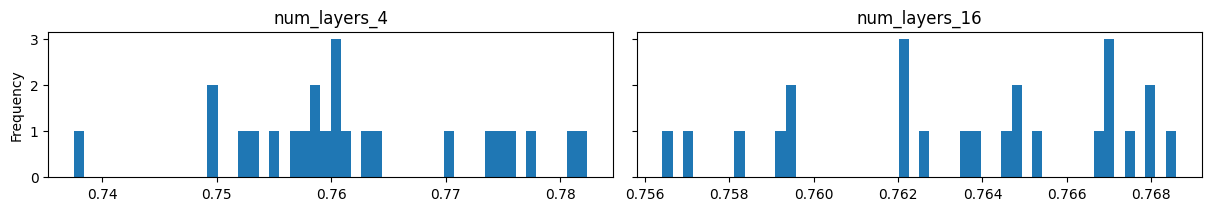

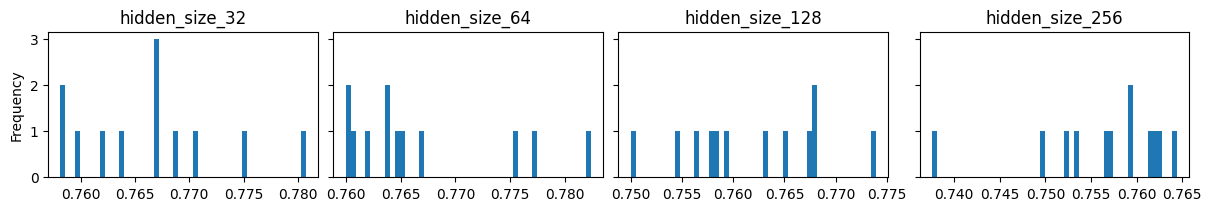

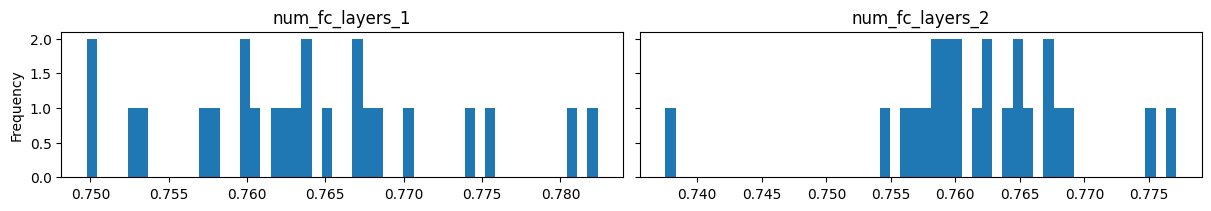

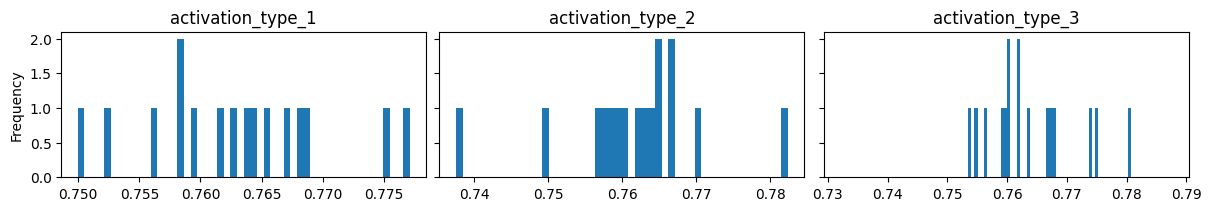

In [24]:
accuracy_desc = sorted_results["mean_accuracy"].astype("float32").describe()
xlimit_range = [
    accuracy_desc["min"] - accuracy_desc["std"],
    accuracy_desc["max"] + accuracy_desc["std"],
]
for hperparameter_name in turning_parameters:
    parameter_group = sorted_results.groupby(hperparameter_name)
    fix, axs = pyplot.subplots(
        1,
        len(parameter_group),
        layout="constrained",
        sharex=False,
        sharey=True,
        figsize=(12, 2),
    )
    for i, g in enumerate(parameter_group):
        g[1]["mean_accuracy"].astype("float32").plot(
            kind="hist", bins=50, subplots=True, sharex=False, sharey=True, ax=axs[i]
        )
        axs[i].set_title(f"{hperparameter_name}_{g[0]}")

pyplot.xlim(xlimit_range)
pyplot.show()

In [25]:
sorted_results_file = f"{log_dir}/sorted_results.csv"
sorted_results = pd.read_csv(sorted_results_file, dtype="str")
best_config = sorted_results.loc[0]
print(best_config)
# id_str_of_best = f"5_5_0.01_{best_config.momentum}_{best_config.optim_type}_{best_config.num_layers}_{best_config.hidden_size}_{best_config.num_fc_layers}_{best_config.activation_type}"
# best_model_name = f"/mnt/AIWorkSpace/work/fin-ml/runs/{_TARGET_STK}/{time_str}/{id_str_of_best}.pt"
# print(best_model_name)

Unnamed: 0                           4
mean_accuracy       0.7823684782608694
trial_id                   d8976_00004
return_period                        5
seq_len                              5
lr                                0.01
momentum           0.11646759543664197
optim_type                           1
num_layers                           4
hidden_size                         64
num_fc_layers                        1
activation_type                      2
Name: 0, dtype: object


In [27]:
import math
from sklearn.metrics import mean_squared_error

pd.set_option("display.precision", 5)

model, config = load_model(f"{log_dir_base}/{task_name}.pt")
model.to(device)

train_loader, test_loader, features_size = prepare_dataloader(config["return_period"])
model.eval()

(trainAccuracy, trainF1) = eval_dl_method(model, train_loader, device=device)
(testAccuracy, testF1) = eval_dl_method(model, test_loader, device=device)
print(f"Train Accuracy: {trainAccuracy:.2f}\nTest Accuracy: {testAccuracy:.5f}")
print(f"Train F1: {trainF1:.2f}\nTest F1: {testF1:.5f}")

Train Accuracy: 0.87
Test Accuracy: 0.76500
Train F1: 0.00
Test F1: 0.00000
